# This notebook produces cluster star results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import h5py
import tqdm
from chronology import setup, run_mcmc, make_plots
from isochrones import StarModel

from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Douglas Hyades file.

In [2]:
df1 = pd.read_csv("hyades_douglas.csv", skiprows=76)

Load the K2-Gaia crossmatch

In [3]:
from astropy.io import fits

with fits.open("k2_dr2_1arcsec.fits") as data:
    df2 = pd.DataFrame(data[1].data)

In [13]:
# for i in df2.keys():
#     print(i)

Merge the Douglas and Gaia catalogues.

In [18]:
# Just select K2 campaign 4 so you don't fill the memory.
m = df2.k2_campaign_str.values == "4"
#df3 = df2.iloc[m]
EPIC = df2.epic_number.values[m]
kepmag = df2.k2_kepmag.values[m]
kepmag_err = df2.k2_kepmagerr.values[m]
gmag = df2.phot_g_mean_mag.values[m]
bp = df2.phot_bp_mean_mag.values[m]
rp = df2.phot_rp_mean_mag.values[m]
parallax = df2.parallax.values[m]
parallax_err = df2.parallax_error.values[m]
ra, ra_err = df2.ra.values[m], df2.ra_error.values[m]
dec, dec_err = df2.dec.values[m], df2.dec_error.values[m]

# Create a mini Gaia catalogue
df3 = pd.DataFrame(dict({"EPIC": EPIC,
                         "gmag": gmag,
                         "bp": bp,
                         "rp": rp,
                         "kepmag": kepmag, "kepmag_err": kepmag_err,
                         "parallax": parallax,
                         "parallax_err": parallax_err,
                         "ra": ra, "ra_err": ra_err,
                         "dec": dec, "dec_err": dec_err
}))
df3.to_csv("K2_c4_gaia.csv")

# Merge Douglas and Gaia
df = pd.merge(df1, df3, left_on="EPIC", right_on="EPIC")

Reformat the rotation period column.

In [15]:
prot = np.zeros(len(df))
for i, p in enumerate(df.K2Per.values):
    if p == "          ":
        prot[i] = 0
    else:
        prot[i] = p

print(prot)
df["prot"] = prot

[ 1.8088  0.      0.     12.3168  0.8584  0.     12.5745 14.6609 14.3802
  0.      0.7257 23.1244  0.8686  0.     20.7309  1.2774  1.3183  0.
  1.8626  2.6612 11.6032  0.2967  0.8037 13.8499  0.4812  0.      9.3908
 21.021  21.021   0.8968  2.3094  1.8443  1.8884  1.8489  0.      0.
  1.4486 49.3166 12.8433  2.3788  8.685   0.      3.6508 10.1182  1.8626
  2.3381 20.3105 43.592   3.6375  0.205   0.     10.017   2.4191  2.4191
 11.4703  0.      0.      0.      0.     10.9678 10.9678  0.      0.
  0.      0.      0.      0.      1.0542  1.0542 11.1304 11.1304  2.4427
  2.4427]


In [16]:
df.to_csv("hyades.csv")
df.head()
# for i in df.keys():
#     print(i)

,[RSP2011],HIP,RAJ2000,DEJ2000,2MASS,EPIC,Kpmag,Mass,Bin,Ap,...,dec_err,gmag,kepmag,kepmag_err,parallax,parallax_err,ra,ra_err,rp,prot
0,64,,03 34 10.5,+22 04 21.2,03341053+2204213,210942999,13.68,0.17,2,4.0,...,0.062352,14.610085,13.675,999999,28.166407,0.096785,53.544861,0.084542,13.300308,1.8088
1,,,03 40 45.8,+17 34 47.7,03404581+1734477,210643507,16.64,0.13,0,3.0,...,0.088322,16.269011,16.638,999999,23.805453,0.146640,55.191643,0.114236,14.877822,0.0000
2,75,,03 42 04.4,+16 25 18.3,03420441+1625183,210563410,15.13,0.18,0,2.0,...,0.059111,14.872567,15.128,999999,23.380591,0.101480,55.519163,0.088386,13.567423,0.0000
3,78,,03 43 47.0,+20 51 36.4,03434706+2051363,210865372,13.38,0.32,0,2.5,...,0.038860,13.336599,13.380,999999,22.088883,0.064101,55.946823,0.056599,12.140936,12.3168
4,80,,03 46 59.5,+15 24 16.8,03465952+1524170,210499476,14.16,0.18,2,4.0,...,0.082477,13.963063,14.165,999999,35.274509,0.132403,56.749149,0.143451,12.665202,0.8584


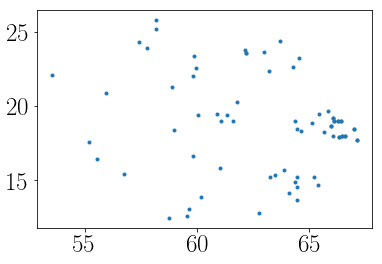

In [17]:
plt.plot(df.ra, df.dec, ".")

In [20]:
df2 = pd.read_csv("../data/hyades_radick.csv", skiprows=1)
df2.head()

,B-V,B-V_err,P,P_err,A,A_err
0,0.535,0.01,5.87,0.03,0.625,0.05
1,0.543,0.01,5.13,0.02,0.625,0.05
2,0.566,0.01,5.45,0.02,0.625,0.05
3,0.597,0.01,8.05,0.06,0.625,0.05
4,0.601,0.01,7.10,0.05,0.625,0.05


Text(0,0.5,'$\\log_{10}(P_{\\mathrm{rot}})$')

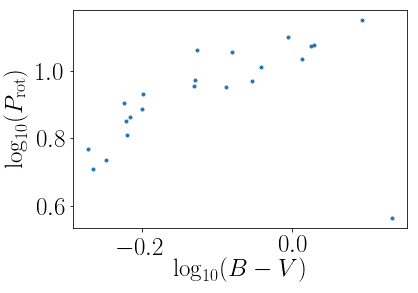

In [24]:
plt.errorbar(np.log10(df2["B-V"]), np.log10(df2.P), fmt=".")
plt.xlabel("$\log_{10}(B-V)$")
plt.ylabel("$\log_{10}(P_{\mathrm{rot}})$")

Create the "obs" dataframe needed for chronology.

In [91]:
obs = pd.DataFrame(dict({"EPIC": df.EPIC,
                         "gmag": df.gmag, "gmag_err": np.zeros(len(df))+.01,  # Find out what the error actually is
                         "bp": df.bp, "bp_err": np.zeros(len(df))+.01,
                         "rp": df.rp, "rp_err": np.zeros(len(df))+.01,
                         "kepmag": df.kepmag, "kepmag_err": df.kepmag_err,
                         "parallax": df.parallax, "parallax_err": df.parallax_err,
                         "prot": df.prot, "prot_err": df.prot.values*.1
}))

In [98]:
# Set up the StarModel object needed to calculate the likelihood.
param_dict = {"G": (obs.gmag, obs.gmag_err),
              "Kp": (obs.kepmag, obs.kepmag_err),
              "parallax": (obs.parallax, obs.parallax_err)  # Isochrones.py takes milliarcseconds
              }

mod = StarModel(mist, **param_dict)  # Set up the StarModel isochrones object.
args = [mod, obs.prot, obs.prot_err, obs.BV, gyro_only, iso_only]  # the lnprob arguments

1     16.269011
2     14.872567
3     13.336599
4     13.963063
5     16.065794
6      9.787785
7     10.572748
8     16.261477
9      9.766113
10    15.706417
11    13.017426
12    15.111156
13     8.840317
14    12.076345
15    14.344322
16    14.676657
17    13.754287
18    14.703896
19    13.329974
20     9.774549
21    16.303532
22    15.069968
23    10.833858
24    14.523818
25    14.685039
26     9.189675
27    12.558902
28    12.627023
29    16.540541
        ...    
43    13.771758
44     9.159913
45    14.620120
46    14.011936
47    12.509938
48    14.314161
49    16.667233
50    12.086519
51     9.108309
52    15.481036
53    15.481036
54     9.645082
55    15.161274
56    15.161274
57    14.961833
58    14.961833
59    11.949200
60    11.949200
61    10.607862
62    10.607862
63    13.705348
64    13.705348
65     8.749313
66     8.749313
67    14.327611
68    14.327611
69     9.782602
70     9.782602
71    11.349087
72    11.349087
Name: gmag, Length: 73, dtype: float32, 

TypeError: float() argument must be a string or a number, not 'tuple'